# 25,000 Steps no iterations

In [1]:
import numpy as np
import custom_hd159062_lnlike as custom_lnlike
from orbitize import sampler,driver,kepler,system,results,lnlike
import multiprocessing as mp
import matplotlib.pyplot as plt
from numpy import loadtxt
import pandas as pd
import pickle
from matplotlib.backends.backend_pdf import PdfPages
import corner
import pandas as pd
from astropy.time import Time
from datetime import datetime
import os

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=17)
plt.rc('axes', linewidth=1)

In [3]:
def M2tperi(M,P,tref):
    Tp = tref - M*P/(2*np.pi)
    return Tp #time of periastron from mean anomaly

def M2tau0(M,P,tref):
    Tp = M2tperi(M,P,tref)
    tau = Tp/P % 1
    return tau #tau from mean anomaly

def tau0(Tp,ref_epoch,P):
    return (Tp - ref_epoch)/P #fraction of orbit after tperi

def p2sma(P,m0,m1):
    return ((P/365.25)**2*(m0+m1))**(1/3) #sma in AU

def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days

In [4]:
path = '../tests/'
data = pd.read_csv(path+'ofti_testdata2.csv')
parameters = pd.read_csv(path+'test_params_ofti.csv',
                        header=None,names=['m0','m1','P','ecc','argp','lan','inc','tperi','plx','gamma','sigma'])
parameters

,m0,m1,P,ecc,argp,lan,inc,tperi,plx,gamma,sigma
0,1.260009,0.126999,2868.628940,0.352301,3.344282,5.962902,0.276812,500.0,68.512183,19.926598,17.552103
1,2.691472,0.224915,1515.633122,0.456186,2.787863,1.156068,0.818435,500.0,36.652872,13.535124,5.262091
2,1.968771,0.163158,422.533423,0.384568,3.150295,5.238748,0.990552,500.0,57.775389,89.591452,6.975695
3,1.598148,0.121401,5607.818863,0.421001,0.417945,5.730352,0.491561,500.0,52.746845,18.699294,8.919145
4,1.922732,0.247321,4118.989625,0.336798,2.172223,2.084670,1.053664,500.0,65.369622,55.312477,2.637387


In [5]:
#from period to semi-major axis:
def p2sma(P,m0,m1):
    return ((P/365.25)**2*(m0 + m1))**(1/3)
#from semi-major axis to period:
def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days
    
#converting from time of periastron (Tp) to epoch of periastron in P praction (tau) for orbitize parameter
def tau0(Tp,ref_epoch,P):
    return (Tp - ref_epoch)/P
#converting from practional time of periastron (tau) to time of periastron (Tp) for toy parameter
def Tperi(tau,ref_epoch,P):
    return ref_epoch + tau*P
    
#from our parameter order to orbitize parameter order:
def toy2orb(toy_params):
    orb_order = [2,3,6,4,5,7,8,9,10,1,0]
    orb_realparams = [toy_params[i] for i in orb_order]
    tau = tau0(orb_realparams[5],0.0,orb_realparams[0])
    sma = p2sma(orb_realparams[0],orb_realparams[-1], orb_realparams[-2])
    #mtot = orb_realparams[-1]+orb_realparams[-2]
    orb_realparams[0] = sma
    orb_realparams[5] = tau
    #orb_realparams.append(mtot)
    return orb_realparams #returns real parameters ordered to fit orbitize kepler solver

In [6]:
test_params = toy2orb(parameters.loc[2])
test_params

[1.4183109209765556,
 0.3845681491983952,
 0.9905515264786352,
 3.1502952867497487,
 5.2387475501602605,
 1.1833383416439425,
 57.77538928989947,
 89.59145189583548,
 6.975695277925178,
 0.16315771473985938,
 1.968770878296065]

In [7]:
def calc_orbit(theta,time):
    #theta are the parameters (array or list form), and time are the observation epochs (also a list or an array)
    """Arguments (theta):
        [0]: m1 (mass of the star)
        [1]: m2 (mass of orbiting body)
        [2]: P (period in days)
        [3]: ecc (eccentricity between 0.0 and 1.0)
        [4]: argp (argument of periastron)
        [5]: lan (longitude of the ascending node)
        [6]: inc (inclination in radians between 0 and 2pi)
        [7]: tperi (time of periastron in days)
        [8]: plx (parallax in mas)
        [9]: gamma (rv zero-point offset in m/s)
        [10] sigma (jitter in m/s)
        
        time has shape len(N_obs)"""
    #first thing we have to do is figure out the average angular velocity in rad/day:
    n = 2*np.pi/theta[2]
    M = n*(time - theta[7]) #Mean anomaly as a function of time in radians
    M = np.mod(M,2*np.pi)
    
    ecc_arr = np.ones(len(M))*theta[3]
    
    E = kepler._calc_ecc_anom(M,ecc_arr) #eccentric anomaly
    
    nu = 2*np.arctan(np.sqrt((1 + theta[3])/(1 - theta[3]))*np.tan(E/2))
    #print(nu)
    #needed for astrometry data:
    sma = ((theta[2]/365.25)**2*(theta[0] + theta[1]))**(1/3) #calculating the semi-major axis in AU
    
    radius = sma*(1.0 - theta[3]*np.cos(E)) #calculating the radius as a function of E
    
    #X,Y are arrays of length time
    Y = radius*(np.cos(theta[5])*np.cos(theta[4] + nu) - np.sin(theta[5])*np.sin(theta[4] + nu)*np.cos(theta[6])) #DEC
    X = radius*(np.sin(theta[5])*np.cos(theta[4] + nu) + np.cos(theta[5])*np.sin(theta[4] + nu)*np.cos(theta[6])) #RA
    
    dra = X*theta[8]
    ddec = Y*theta[8]
    
    #needed for radial velocity data:
    #Jupiter in solar masses: 0.0009543:
    m_jup = 0.0009543
    
    #radial velocity amplitude in m/s:
    K0 = (28.4329/np.sqrt(1-theta[3]**2))*\
    (theta[1]*np.sin(theta[6])/m_jup)*((theta[0] + theta[1])**(-2/3))*\
    (theta[2]/365.25)**(-1/3)
    #print(K0)
    
    #Radial velocity in m/s:
    argp_star = theta[4] + np.pi
    rv0 = K0*(np.cos(argp_star + nu) + theta[3]*np.cos(argp_star)) + theta[9] #same shape as nu (same shape as time)
    return dra,ddec,rv0

In [8]:
raoff,decoff,rv = calc_orbit(parameters.loc[2],np.arange(0,parameters.loc[2][2]))

In [14]:
data

,epoch,object,raoff,raoff_err,decoff,decoff_err,rv,rv_err
0,14.443894,0,NaN,NaN,NaN,NaN,0.732870,0.005
1,2.349522,0,NaN,NaN,NaN,NaN,0.257480,0.005
2,26.737912,0,NaN,NaN,NaN,NaN,1.303266,0.005
3,82.759658,0,NaN,NaN,NaN,NaN,3.545633,0.005
4,54.753542,0,NaN,NaN,NaN,NaN,2.890583,0.005
5,52.623542,0,NaN,NaN,NaN,NaN,2.767194,0.005
6,44.864129,0,NaN,NaN,NaN,NaN,2.313228,0.005
7,84.386835,0,NaN,NaN,NaN,NaN,3.512405,0.005
8,23.139671,0,NaN,NaN,NaN,NaN,1.122638,0.005
9,29.082474,0,NaN,NaN,NaN,NaN,1.437687,0.005


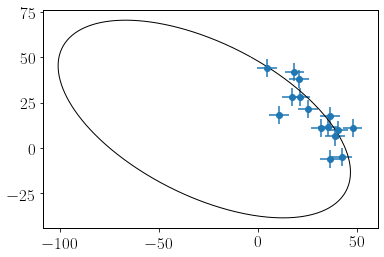

In [9]:
plt.plot(raoff,decoff,'k',lw=1)
plt.errorbar(data['raoff'],data['decoff'],yerr=data['decoff_err'],xerr=data['raoff_err'],fmt='o')
plt.show()

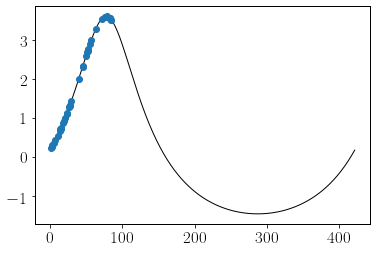

In [18]:
plt.plot(np.arange(0,parameters.loc[2][2]),rv/1000.0,'k',lw=1)
plt.errorbar(data['epoch'],data['rv'],yerr=data['rv_err'],fmt='o')
plt.show()

In [29]:
# system parameters
num_secondary_bodies = 1
system_mass = test_params[-1] # [Msol]
plx = test_params[6] # [mas]
mass_err = 0.05 # [Msol]
plx_err = 0.05 # [mas]

# MCMC parameters
num_temps = 20
num_walkers = 100
num_threads = mp.cpu_count() # or a different number if you prefer


my_driver = driver.Driver(
    '../tests/ofti_testdata2.csv', 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    system_kwargs = {'fit_secondary_mass':True,
                                  'tau_ref_epoch':0, 'gamma_bounds':(-5000, 5000), 'jitter_bounds':(1e-3, 50)},
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads}
)

In [30]:
total_orbits = 2500000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 100 # steps to burn in per walker
thin = 50# only save every 10th step

In [31]:
s = my_driver.sampler

In [32]:
s.run_sampler(total_orbits, burn_steps=0, thin=thin)
chain = my_driver.sampler.chain

Burn in complete


/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.

25000/25000 steps completed
Run complete


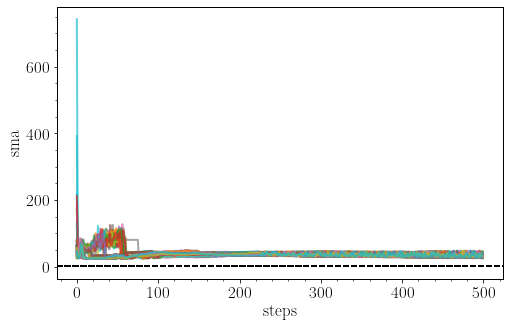

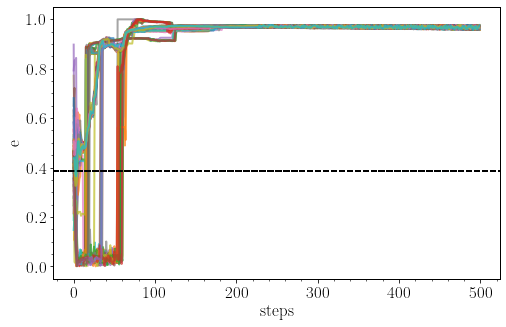

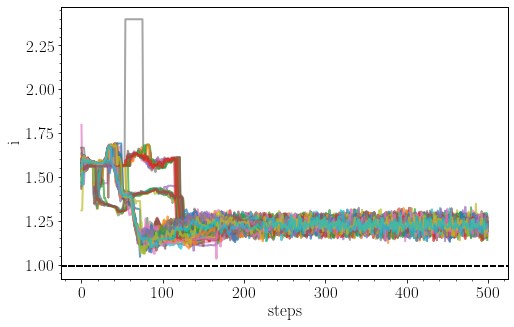

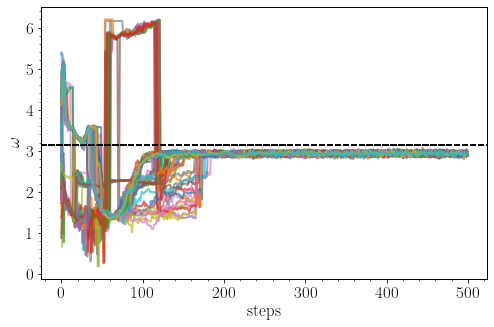

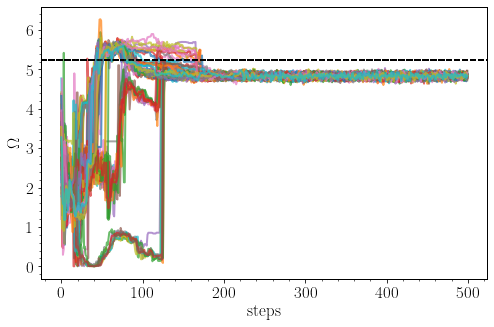

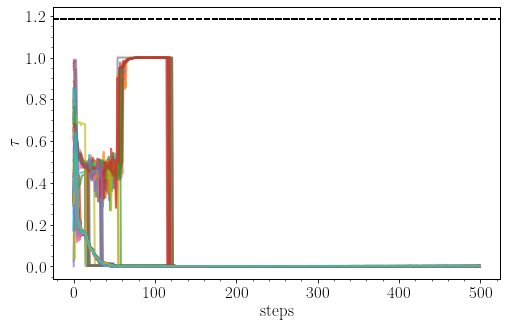

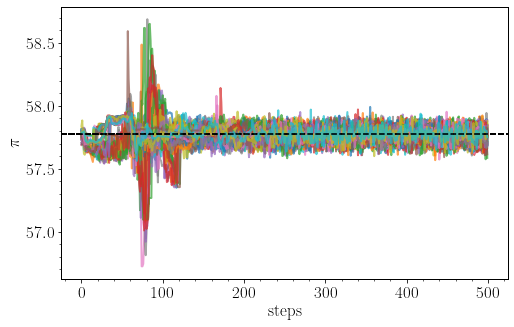

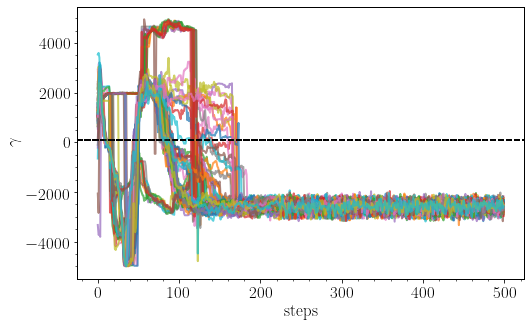

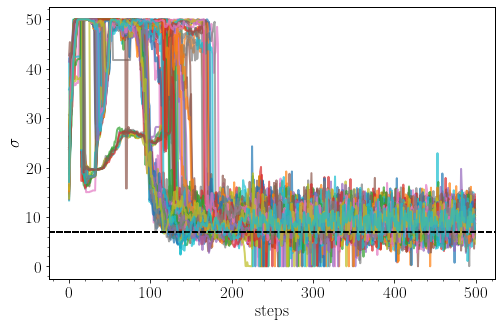

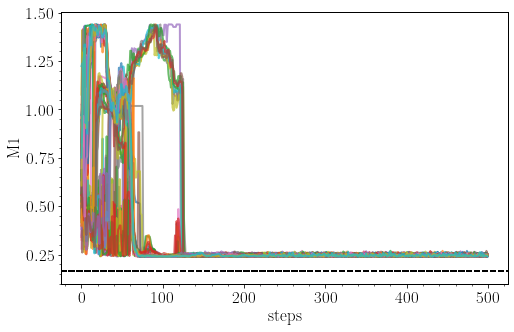

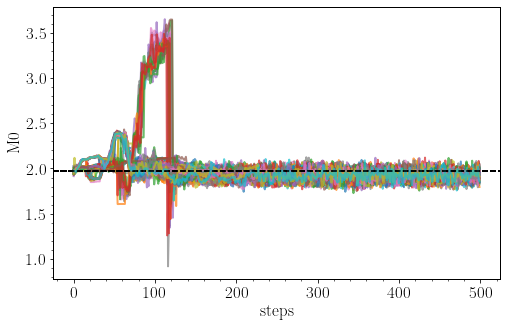

In [34]:
param_names = ['sma','e','i','$\omega$','$\Omega$','$\\tau$','$\pi$','$\gamma$',
               '$\sigma$','M1','M0']
shape = np.shape(chain)
num_steps = shape[2]
num_params = shape[3]
num_walkers = shape[1]
for p in range(num_params):
    pname = param_names[p]
    fig = plt.figure(figsize = (8,5))
    for x in range(num_walkers):
        #makes trend plot
        plt.plot(range(num_steps),my_driver.sampler.chain[0,x,:,p],alpha=0.7,linewidth=2)
        plt.axhline(test_params[p],ls='--',c='k')
    plt.ylabel(pname)
    plt.xlabel('steps')
    plt.minorticks_on()
    plt.show()

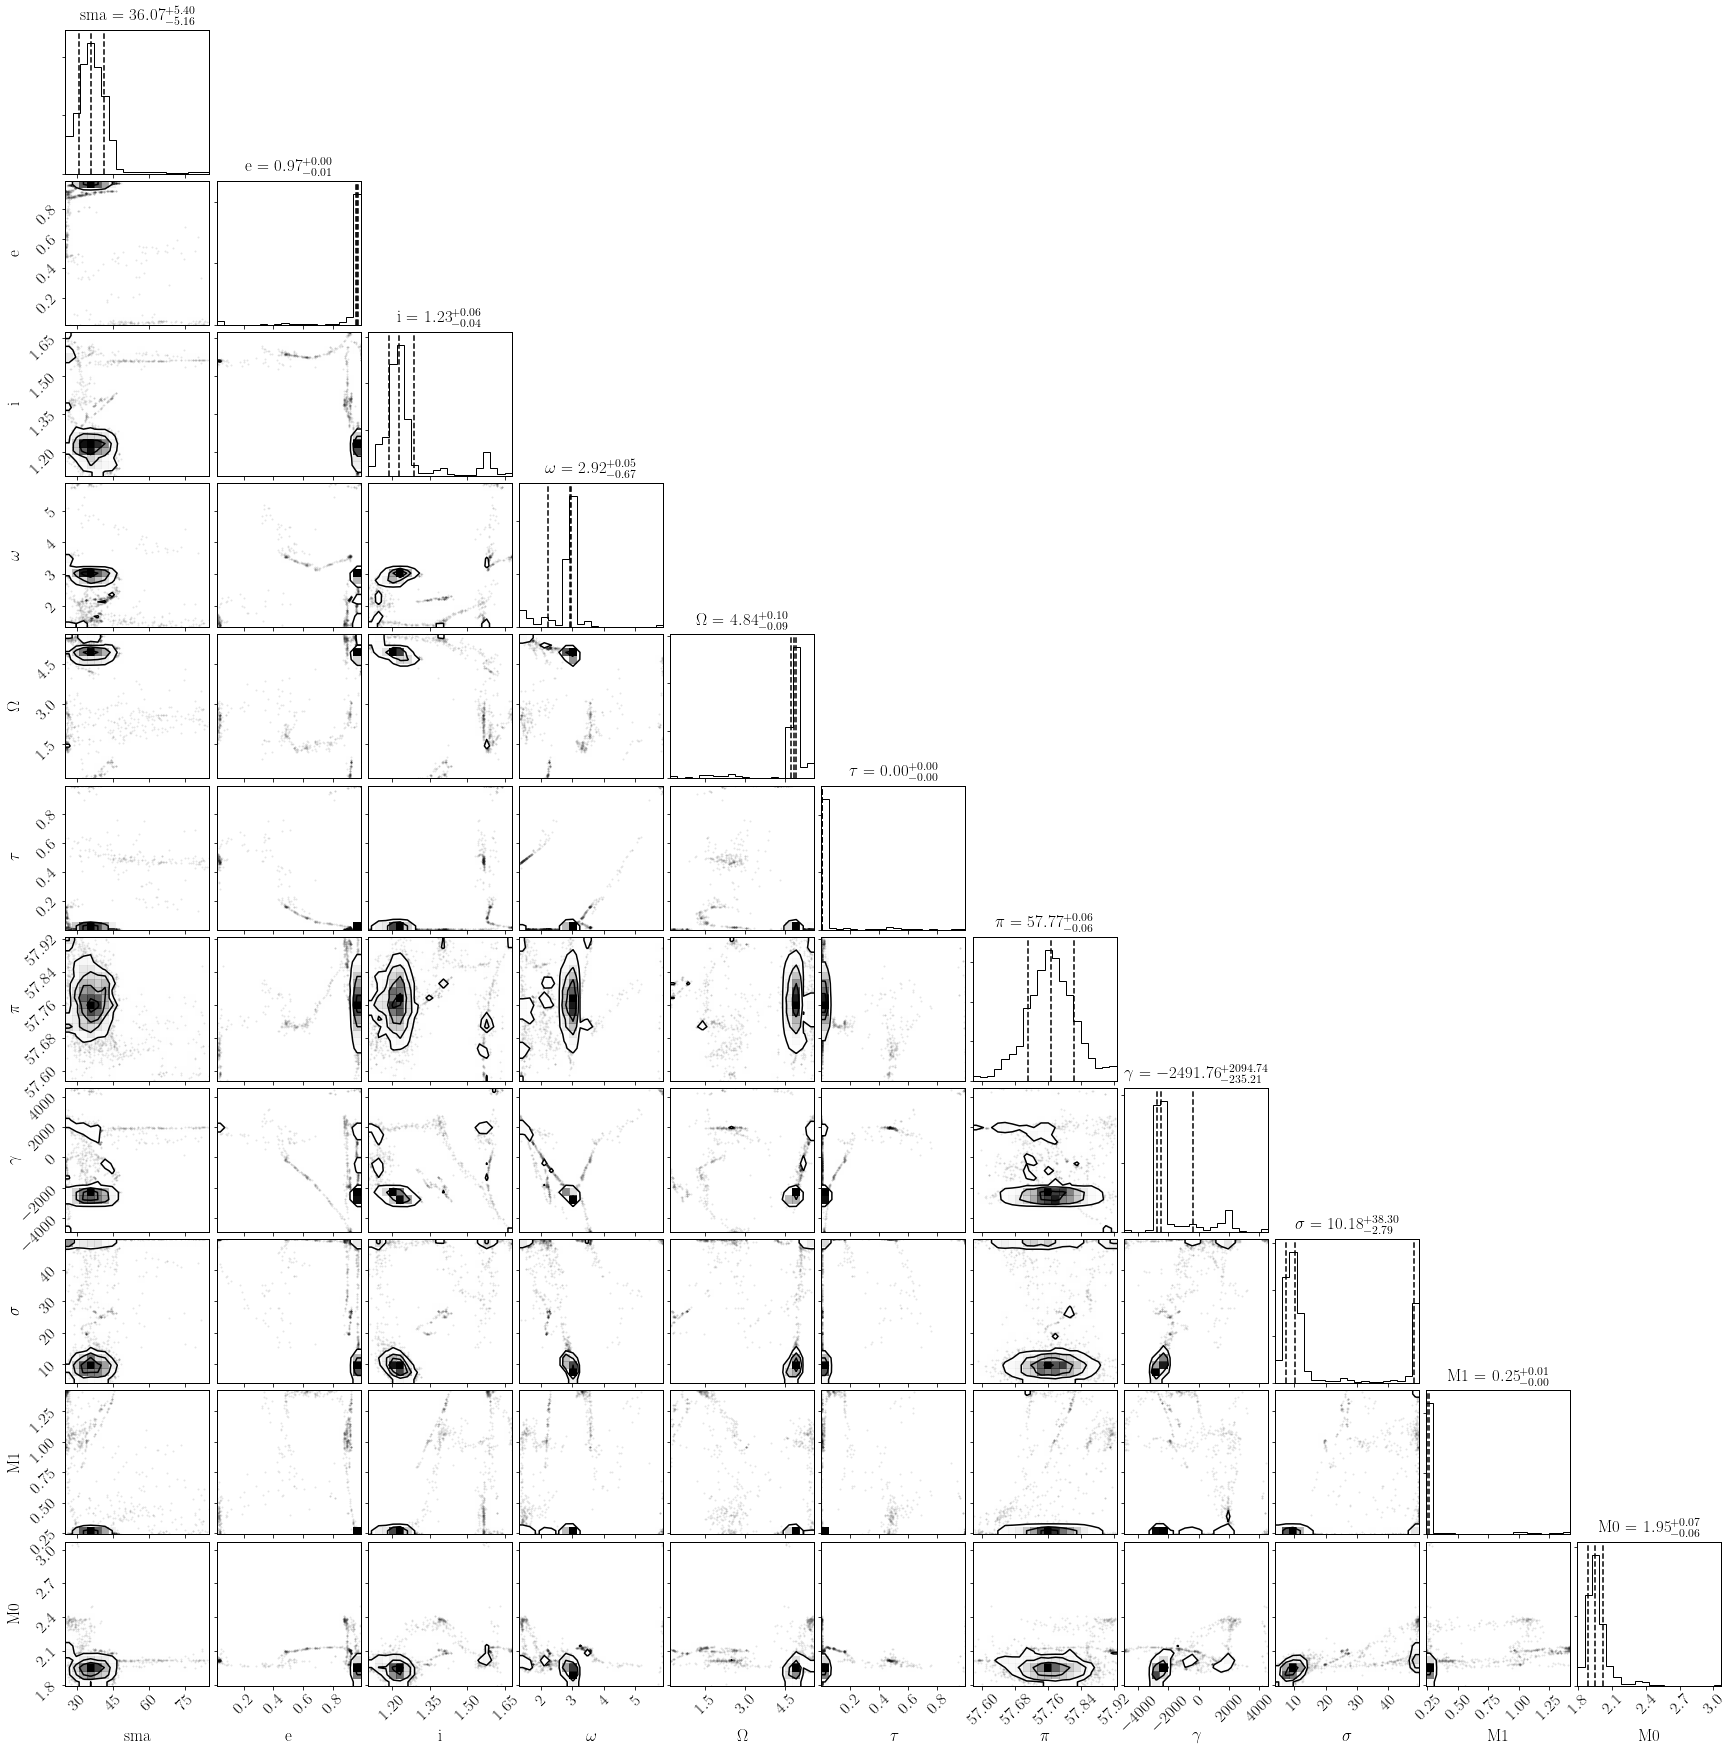

In [45]:
flatchain = np.reshape(chain[0],(-1,11))
flatchain = flatchain[-5000:,:]
corner_fig = corner.corner(flatchain,labels = param_names,quantiles=[0.16,0.5,0.84],
                          show_titles=True,
                           range=np.ones(len(param_names))*0.99,
                           title_kwargs={"fontsize": 17})

In [41]:
np.shape(flatchain)

(5000, 11)

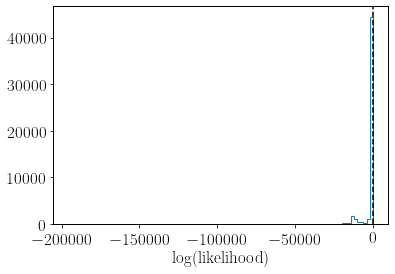

In [55]:
plt.hist(s.lnlikes,bins=100,histtype='step')
plt.axvline(x=np.median(s.lnlikes),c='k',ls='--')
plt.xlabel('$\log(\mathrm{likelihood})$')
#plt.xlim(-2000,2000)
plt.show()

In [56]:
median_pars = np.median(flatchain,axis=0)
print(median_pars)

[ 3.60749420e+01  9.68050413e-01  1.22759800e+00  2.92056333e+00
  4.83637142e+00  1.30257886e-03  5.77667433e+01 -2.49176287e+03
  1.01798206e+01  2.45103531e-01  1.94934225e+00]


In [57]:
#from semi-major axis to period:
def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days

def Tperi(tau,ref_epoch,P):
    return ref_epoch + tau*P

#changing the orbitize paramter output order from orbitize to fit in our calc_orbit function
def orb2toy(orb_params):
    toy_order = [10,9,0,1,3,4,2,5,6,7,8]
    orb_testparams = [orb_params[i] for i in toy_order]
    period = sma2p(orb_testparams[2],orb_testparams[0],orb_testparams[1])
    orb_testparams[2] = period
    tperi = Tperi(orb_testparams[7],0.0,orb_testparams[2])
    orb_testparams[7] = tperi

    return orb_testparams

In [58]:
parameters

,m0,m1,P,ecc,argp,lan,inc,tperi,plx,gamma,sigma
0,1.260009,0.126999,2868.628940,0.352301,3.344282,5.962902,0.276812,500.0,68.512183,19.926598,17.552103
1,2.691472,0.224915,1515.633122,0.456186,2.787863,1.156068,0.818435,500.0,36.652872,13.535124,5.262091
2,1.968771,0.163158,422.533423,0.384568,3.150295,5.238748,0.990552,500.0,57.775389,89.591452,6.975695
3,1.598148,0.121401,5607.818863,0.421001,0.417945,5.730352,0.491561,500.0,52.746845,18.699294,8.919145
4,1.922732,0.247321,4118.989625,0.336798,2.172223,2.084670,1.053664,500.0,65.369622,55.312477,2.637387


In [59]:
pred_params = orb2toy(median_pars)

In [60]:
print(pred_params)

[1.949342245439018, 0.24510353064339846, 53423.98265530494, 0.9680504127894644, 2.9205633281095045, 4.836371424398245, 1.227598003376452, 69.58895030054398, 57.76674326908533, -2491.7628739428787, 10.1798206330791]


In [61]:
raoff_pred,decoff_pred,rv_pred = calc_orbit(pred_params,np.arange(0,pred_params[2]))

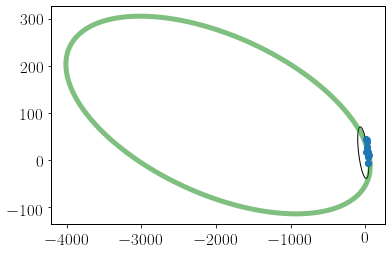

In [63]:
plt.plot(raoff,decoff,'k',lw=1)
plt.plot(raoff_pred,decoff_pred,'g',lw=5,alpha=0.5)
plt.errorbar(data['raoff'],data['decoff'],yerr=data['decoff_err'],xerr=data['raoff_err'],fmt='o')
#plt.xlim(-500,500)
#plt.ylim(150,-150)
plt.show()

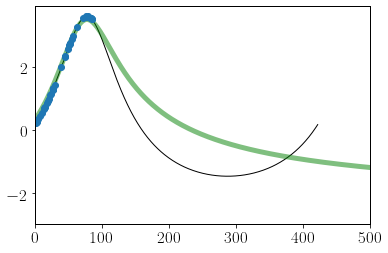

In [64]:
plt.plot(np.arange(0,parameters.loc[2][2]),rv/1000.0,'k',lw=1)
plt.plot(np.arange(0,pred_params[2]),rv_pred/1000.0,'g',lw=5,alpha=0.5)
plt.errorbar(data['epoch'],data['rv'],yerr=data['rv_err'],fmt='o')
plt.xlim(0,500)
plt.show()

In [65]:
max_params = s.post[np.argmax(s.lnlikes)]
best_params = orb2toy(max_params)
raoff_best,decoff_best,rv_best = calc_orbit(best_params,np.arange(0,best_params[2]))

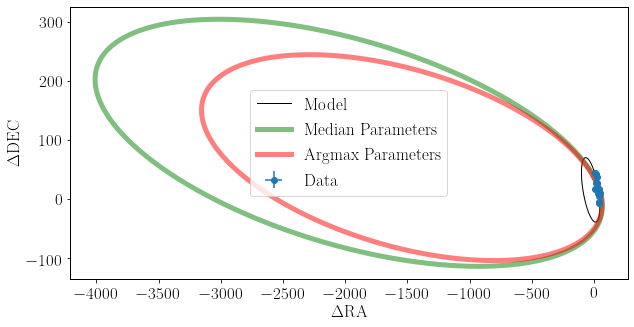

In [66]:
plt.figure(figsize=(10,5))
plt.plot(raoff,decoff,'k',lw=1,label='Model')
plt.plot(raoff_pred,decoff_pred,'g',lw=5,alpha=0.5,label='Median Parameters')
plt.plot(raoff_best,decoff_best,'r',lw=5,alpha=0.5,label='Argmax Parameters')
plt.errorbar(data['raoff'],data['decoff'],yerr=data['decoff_err'],xerr=data['raoff_err'],fmt='o',label='Data')
plt.xlabel('$\Delta$RA')
plt.ylabel('$\Delta$DEC')
plt.legend()
plt.show()